In [1]:
# some_file.py
import sys
# credits to https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking/tree/master
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(0, '../LaurieOnTracking')
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel
import Metrica_PitchControl as mpc


# default libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
%matplotlib inline

import pandas as pd
from scipy.spatial import ConvexHull
from scipy.spatial import distance
import scipy.signal as signal

import numpy as np
from numpy import linalg as LA
from sklearn.preprocessing import MinMaxScaler

# add application folder to path
sys.path.insert(0, '../')
import helpers.fundamentals as fund
import helpers.features as feat

In [2]:
# set up initial path to data
DATADIR = '../sample-data-master/data'
game_id = 1 # let's look at sample match 2

# read in the event data
events = mio.read_event_data(DATADIR,game_id)

# Bit of housekeeping: unit conversion from metric data units to meters
events = mio.to_metric_coordinates(events)
events.head()
#### TRACKING DATA ####

# READING IN TRACKING DATA
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')
# Look at the column namems
print( tracking_home.columns )
# Convert positions from metrica units to meters 
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)
tracking_home, tracking_away, events = mio.change_playing_direction_both(tracking_home, tracking_away,
                                                                                     events)
# add velocities
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True)
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True)


Reading team: home
Reading team: away
Index(['Period', 'Time [s]', 'Home_11_x', 'Home_11_y', 'Home_1_x', 'Home_1_y',
       'Home_2_x', 'Home_2_y', 'Home_3_x', 'Home_3_y', 'Home_4_x', 'Home_4_y',
       'Home_5_x', 'Home_5_y', 'Home_6_x', 'Home_6_y', 'Home_7_x', 'Home_7_y',
       'Home_8_x', 'Home_8_y', 'Home_9_x', 'Home_9_y', 'Home_10_x',
       'Home_10_y', 'Home_12_x', 'Home_12_y', 'Home_13_x', 'Home_13_y',
       'Home_14_x', 'Home_14_y', 'ball_x', 'ball_y'],
      dtype='object')


(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x210c6b97288>)

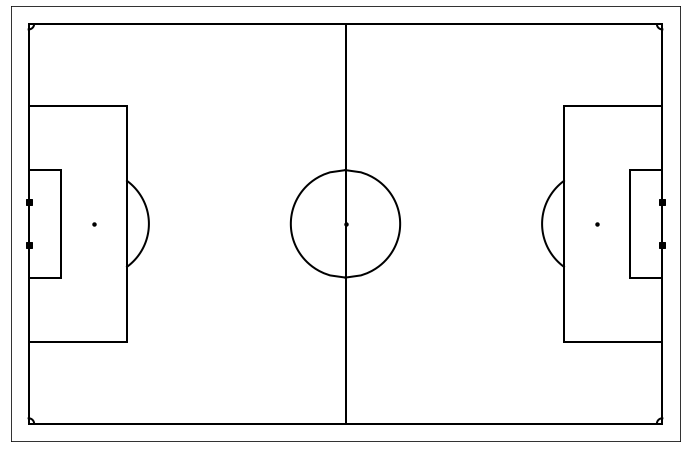

In [3]:
mviz.plot_pitch()

In [4]:
def calc_ball_velocity(team, smoothing=True, filter_='Savitzky-Golay', window=7, polyorder=1, maxspeed=200 / 3.6):
    """  credits to Lauri Shaw (https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking)
    calc_player_velocities( tracking_data )

    Calculate ball velocity in x & y direction, and total ball speed at each timestamp of the tracking data

    Parameters
    -----------
        team: the tracking DataFrame for home or away team
        smoothing: boolean variable that determines whether velocity measures are smoothed. Default is True.
        filter: type of filter to use when smoothing the velocities. Default is Savitzky-Golay, which fits a polynomial of order 'polyorder' to the data within each window
        window: smoothing window size in # of frames
        polyorder: order of the polynomial for the Savitzky-Golay filter. Default is 1 - a linear fit to the velcoity, so gradient is the acceleration
        maxspeed: the maximum speed that a player can realisitically achieve (in meters/second). Speed measures that exceed maxspeed are tagged as outliers and set to NaN.

    Returrns
    -----------
       ball_velo_x : Speed in x direction
       ball_velo_y : Speed in y direction
       ball_velo   : Total speed of the ball

    """
    # index of first frame in second half
    second_half_idx = team.Period.idxmax(2)

    # Calculate the timestep from one frame to the next. Should always be 0.04 within the same half
    dt = team['Time [s]'].diff()

    # difference player positions in timestep dt to get unsmoothed estimate of velicity
    vx = team["ball_x"].diff() / dt
    vy = team["ball_y"].diff() / dt

    if maxspeed > 0:
        # remove unsmoothed data points that exceed the maximum speed (these are most likely position errors)
        raw_speed = np.sqrt(vx ** 2 + vy ** 2)
        vx[raw_speed > maxspeed] = np.nan
        vy[raw_speed > maxspeed] = np.nan

        if smoothing:
            if filter_ == 'Savitzky-Golay':
                # calculate first half velocity
                vx.loc[:second_half_idx] = signal.savgol_filter(vx.loc[:second_half_idx], window_length=window,
                                                                polyorder=polyorder)
                vy.loc[:second_half_idx] = signal.savgol_filter(vy.loc[:second_half_idx], window_length=window,
                                                                polyorder=polyorder)
                # calculate second half velocity
                vx.loc[second_half_idx:] = signal.savgol_filter(vx.loc[second_half_idx:], window_length=window,
                                                                polyorder=polyorder)
                vy.loc[second_half_idx:] = signal.savgol_filter(vy.loc[second_half_idx:], window_length=window,
                                                                polyorder=polyorder)
            elif filter_ == 'moving average':
                ma_window = np.ones(window) / window
                # calculate first half velocity
                vx.loc[:second_half_idx] = np.convolve(vx.loc[:second_half_idx], ma_window, mode='same')
                vy.loc[:second_half_idx] = np.convolve(vy.loc[:second_half_idx], ma_window, mode='same')
                # calculate second half velocity
                vx.loc[second_half_idx:] = np.convolve(vx.loc[second_half_idx:], ma_window, mode='same')
                vy.loc[second_half_idx:] = np.convolve(vy.loc[second_half_idx:], ma_window, mode='same')
    ball_velo_x = vx
    ball_velo_y = vy
    ball_velo = np.sqrt(vx ** 2 + vy ** 2)
    return ball_velo_x, ball_velo_y, ball_velo

ball_velo_x, ball_velo_y, ball_velo_xy = calc_ball_velocity(tracking_home, "Savitzky-Golay", 7, 1, 200/3.6)


In [5]:
def gen_convex_hull(coordinates):
    """ Generate convex hull
    Function that generates the convex hull
    
    Args:
        coordinates: List with the coordinates of the players that are used to calculate the convex hull

    Returns
        hull: scipy.spatial.qhull.ConvexHull that represents the convex hull
    
    """

    #create convex hull
    hull = ConvexHull(coordinates)

    return hull

def vis_convex_hull(hometeam, awayteam, coordinates, hull, frame=1): 
    """ Visualizes convex hull on the pitch
    
    Args:
        hometeam: row (i.e. instant) of the home team tracking data frame
        awayteam: row of the away team tracking data frame
        coordinates: List with the coordinates of the players that are used to calculate the convex hull
        hull: scipy.spatial.qhull.ConvexHull that represents the convex hull
        frame: Integer representing the frame number for the calculation
    
    Returns:
           fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)
    """
    
    # get pitch
    fig, ax = mviz.plot_frame(tracking_home.loc[frame], tracking_away.loc[frame])
    
    #Fill the area within the lines that we have drawn
    ax.fill(coordinates[hull.vertices,0], coordinates[hull.vertices,1], 'k', alpha=0.3)
    return fig, ax

def area_convex_hull(hull):
    """ Calculates area of convex hull on the pitch
    
    Args:
        hull: scipy.spatial.qhull.ConvexHull that represents the convex hull
        
    Returns:
        hull.area: a float with area of the convex hull
    """
    return hull.area

def team_centroid(coordinates):
    """ Calculates the team centroid of a the coordinatexs
    
    Args:
        coordinates: List with the coordinates of the players that are used for calculation

        
    Returns:
        x_centroid: A float that represents the centroid with respect to x-axis
        y_centroid: A float that represents the centroid with respect to y-axis
    """
    x_centroid = np.mean([coordinate[0] for coordinate in coordinates])
    y_centroid = np.mean([coordinate[1] for coordinate in coordinates])
    
    return x_centroid, y_centroid

def vis_team_centroid(hometeam, awayteam, x_centroid, y_centroid, frame=1, side='home'):
    """ Visualizes team centroid on the pitch
    
    Args:
        hometeam: row (i.e. instant) of the home team tracking data frame
        awayteam: row of the away team tracking data frame
        x_centroid: A float that represents the centroid with respect to x-axis
        y_centroid: A float that represents the centroid with respect to y-axis
        frame: Integer representing the frame number for the calculation
        side: boolean indicting if the team coordinates are from the home of away team
    
    Returns:
           fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)
    """
    # get basic pitch 
    fig, ax = mviz.plot_frame(tracking_home.loc[frame], tracking_away.loc[frame], PlayerAlpha=0.7)
    
    #color
    if side=='home':
        colorMarker = 'black'
    else:
        colorMarker = 'blue'
    
    # add centroid
    ax.plot(x_centroid, y_centroid, color=colorMarker, Marker='x', MarkerSize=20, mew=4)
    return fig, ax


def extrema_axis_player(coordinates, extrema='max', axis='y-axis'):
    """ Finds the coordinates of a player for the selected extrema and axis
    
    Args:
        coordinates: List with the coordinates of the players that are used for calculation
        extrema: either 'max' or 'min' indicating the extrema to take
        axis: either 'y-axis' or 'x-axis' indicating the axis to perform the action 

    """
    # Correct for selected axis
    if axis=='y-axis':
        axis_coordinates = [coordinate[1] for coordinate in coordinates]
    elif axis == 'x-axis':
        axis_coordinates = [coordinate[0] for coordinate in coordinates] 
    
    # Correct for selected extrema
    if extrema=='max':
        extrema_player = np.where(axis_coordinates == np.amax(axis_coordinates))[0][0]
    elif extrema=='min':    
        extrema_player = np.where(axis_coordinates == np.amin(axis_coordinates))[0][0]
    x_extrema = coordinates[extrema_player][0]
    y_extrema = coordinates[extrema_player][1]
    #distance = abs(maximum-minimum)
    return x_extrema, y_extrema

def vis_max_axis(hometeam, awayteam, coordinates, axis='y-axis', frame=1, side='home'):
    """ Visualizes line between two outest players on a axis
    
    Args:
        hometeam: row (i.e. instant) of the home team tracking data frame
        awayteam: row of the away team tracking data frame
        coordinates: List with the coordinates of the players that are used for calculation
        axis: either 'y-axis' or 'x-axis' indicating the axis to perform the action 
        frame: Integer representing the frame number for the calculation
        side: boolean indicting if the team coordinates are from the home of away team
    
    Returns:
           fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)
    """
    # get basic pitch
    fig, ax = mviz.plot_frame(tracking_home.loc[frame], tracking_away.loc[frame])

    # Get coordinates of the extreme players
    x_max_player, y_max_player = extrema_axis_player(coordinates, 'max', axis)
    x_min_player, y_min_player = extrema_axis_player(coordinates, 'min', axis)

    # color
    if side=='home':
        colorMarker = 'red'
    else:
        colorMarker = 'blue'
        
    # draw line
    ax.plot([x_max_player, x_min_player], [y_max_player, y_min_player], linestyle='solid', color='red', linewidth= 8, 
            alpha = 0.3)
    return fig, ax

# Todo check
def team_spread(coordinates):
    """ Calculate the team spread using the method of Moura et al. (2012)
    
    Args:
        coordinates: List with the coordinates of the players that are used for calculation

    returns:
        frob_norm: A float representing the team spread
        
    """
    # Calculates the distances between all players
    distances_matrix = distance.cdist(coordinates, coordinates, 'euclidean')
    # get lower triangular matrix
    distances_matrix = np.tril(distances_matrix, k=0)
    # Frobenius norm for matrix
    frob_norm = LA.norm(distances_matrix, 'fro')
    return frob_norm

def stretch_index(coordinates):
    """ Calculate the stretch index using the method of Duarte et al. (2013)
    
    Args:
        coordinates: List with the coordinates of the players that are used for calculation

    returns:
        stretch_index: A float representing the team spread
        
    """
    # Calculate the coordinates of the centroid
    x_centroid, y_centroid = team_centroid(coordinates)
    # Calculate the stretch index
    stretch_index = np.mean([distance.euclidean([x_centroid, y_centroid], [coordinate[0], coordinate[1]]) for coordinate 
                       in coordinates])
    return stretch_index

def rest_defence(x_coordinates, x_ball, side='home'):
    """ Counts the numbers of players behind the ball in a selected frame
    
    Args:
        x_coordinates: A list of x-coordinates of the players in a selected frame
        x_ball: the x-coordinate of the ball
        side: boolean indicting if the team coordinates are from the home of away team

    returns:
        num_players: The number of players behind the ball
        
    """
    
    # Return nan if ball coordinates are unavailable
    if np.isnan(x_ball):
        return np.nan
    
    if (side=='home'):
        num_players = sum(1 if x > x_ball else 0 for x in x_coordinates)
    else:
        num_players = sum(1 if x < x_ball else 0 for x in x_coordinates)
    return num_players

def distance_to_ball(team, teamname, frame, field_dimen = (106.0,68.0)):
    """ Retrieve the euclidean distances to the ball for all players, nan if ball is outside the pitch
    Args:
        team: row (i.e. instant) of the team tracking data frame
        teamname: team name "Home" or "Away"
        frame: Integer representing the frame number for the calculation
        
    Returns:
        coordinates: sorted dictionary with player id and distance to the ball
    """
    ball_x = team.loc[team.index==frame, ['ball_x']].values[0][0]
    ball_y = team.loc[team.index==frame, ['ball_y']].values[0][0]
    
    coordinates = get_coordinates(team, teamname, frame)
    
    # return nan for every player when the ball is outside the patch
    x_limit = field_dimen[0]/2
    y_limit = field_dimen[1]/2
    if (ball_x < -x_limit or ball_x > x_limit):
        distances = {player_id: np.nan for player_id, coordinate 
                   in coordinates.items()} 
        return distance
    if (ball_y < -y_limit or ball_y > y_limit):
        distances = {player_id: np.nan for player_id, coordinate 
                   in coordinates.items()} 
        return distances
    
    # calculate distances
    distances = {player_id: np.linalg.norm(np.array(coordinate) - np.array([ball_x, ball_y])) for player_id, coordinate 
                   in coordinates.items()} 
    # sort
    distances = {k: v for k, v in sorted(distances.items(), key=lambda item: item[1])}
    return distances


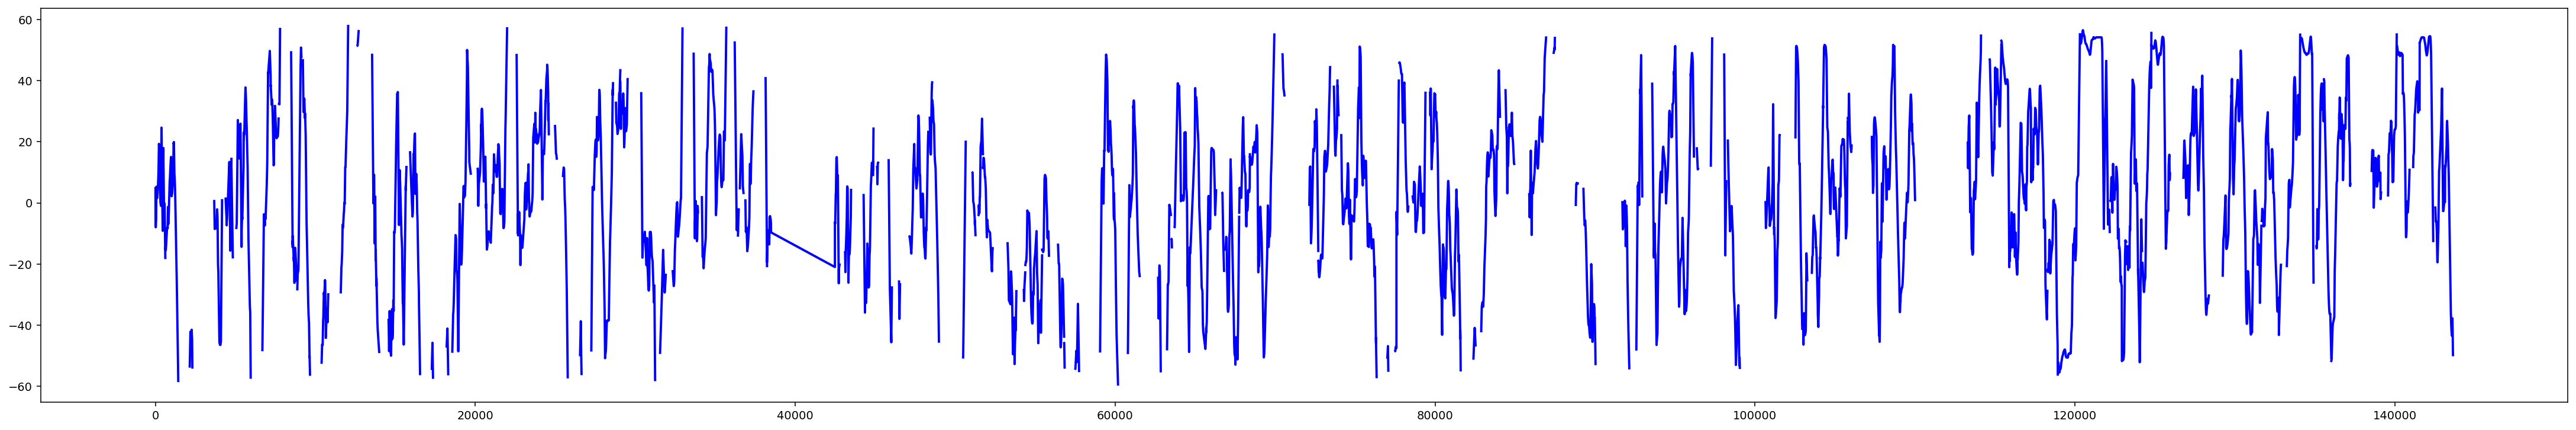

In [6]:
# Plot feature over time
plt.rcParams['figure.figsize'] = [100/2.54, 16/2.54]
plt.rcParams['figure.dpi'] = 140
df = tracking_home
x = df.index
y1 = df['ball_x']
plt.plot(x, y1, marker='', color='b', linewidth=2, label = 'team area')

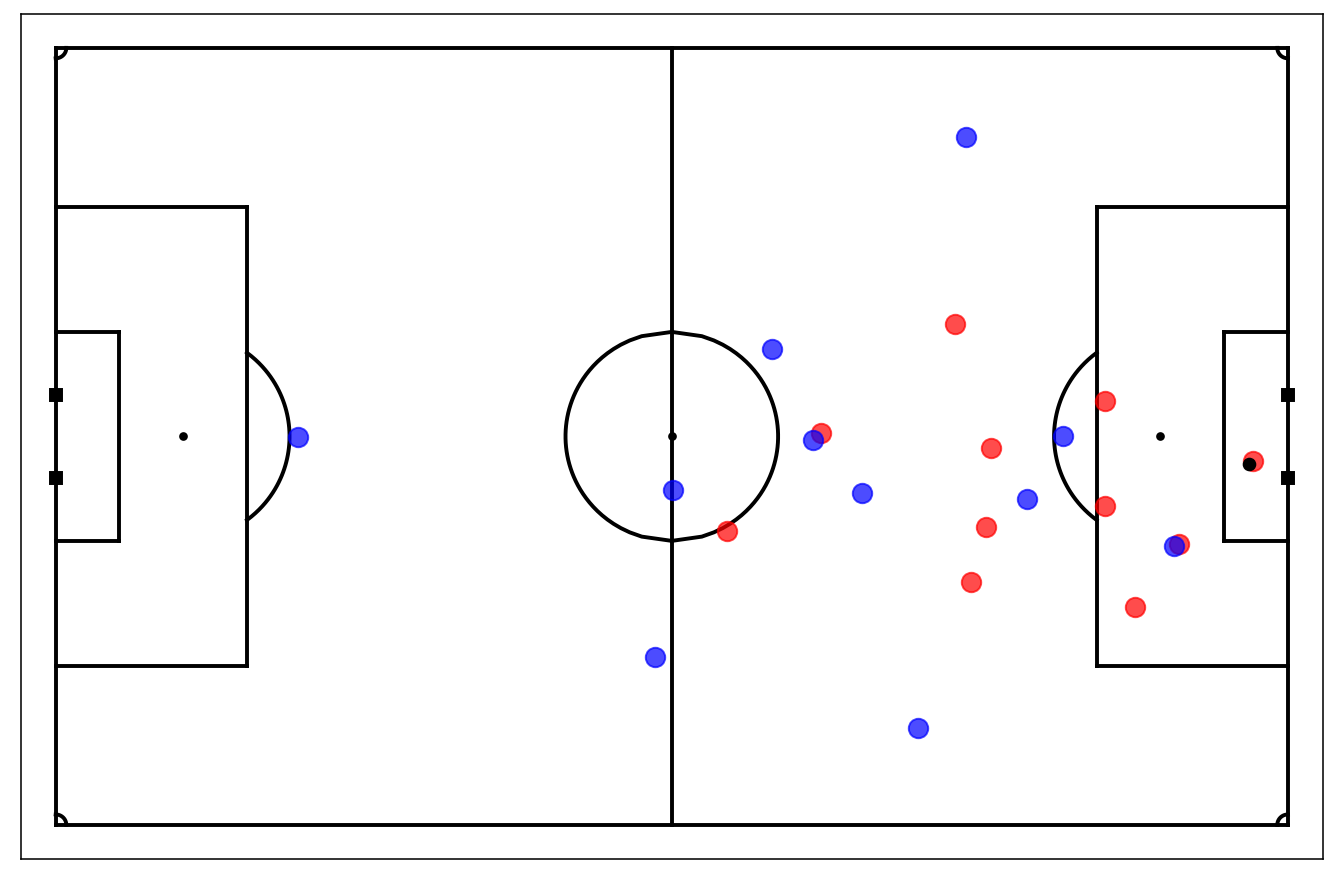

In [7]:
fig, ax = mviz.plot_frame(tracking_home.loc[19485], tracking_away.loc[19485])

..\helpers\fundamentals.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  player_ids = np.delete(player_ids, np.where(player_ids == GKid))


(<Figure size 1680x1120 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x210e20ad848>)

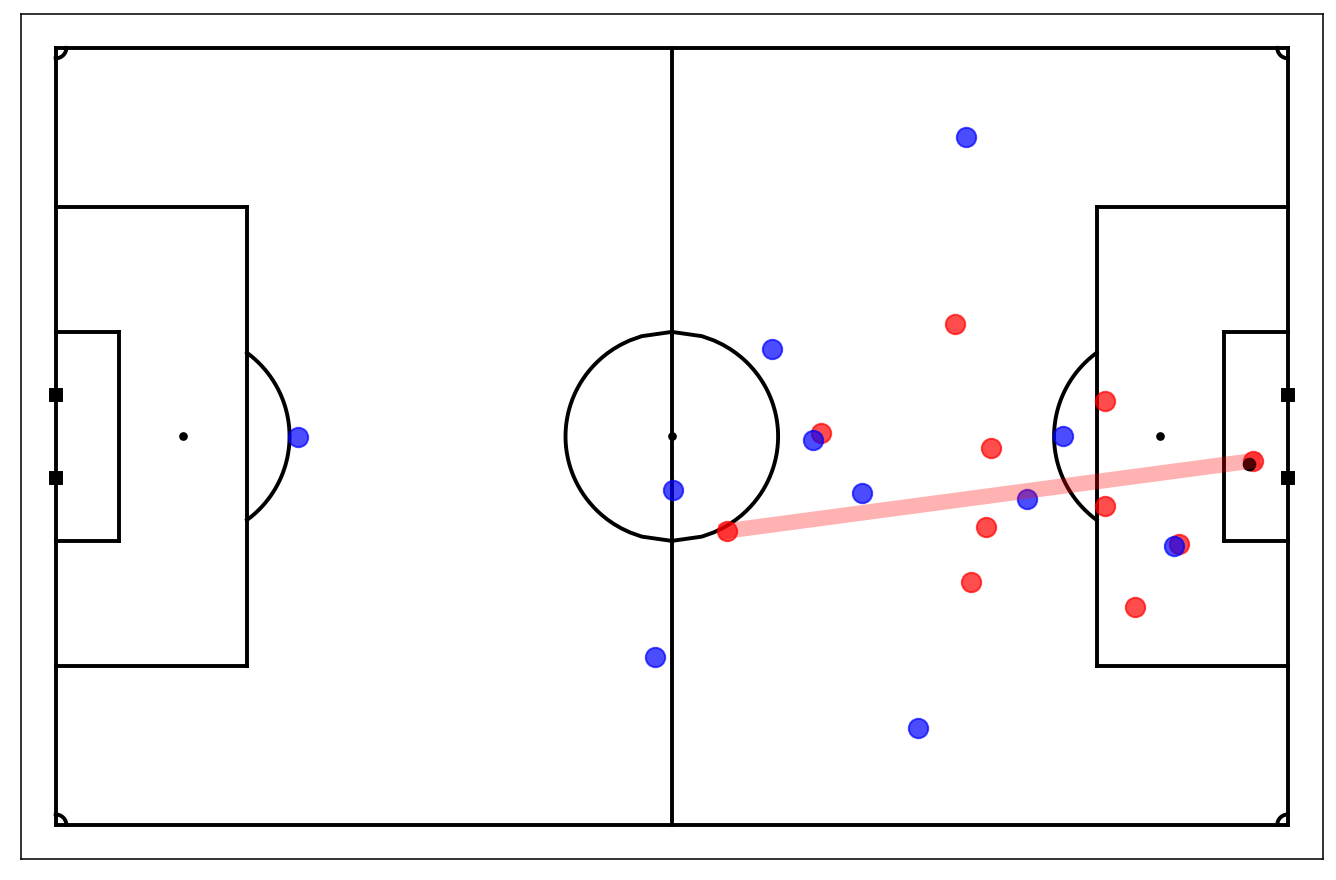

In [8]:
coordinates = np.array(list(fund.get_coordinates(tracking_home, "Home", 19485, np.nan).values()))
x, y = team_centroid(coordinates)
vis_max_axis(tracking_home, tracking_away, coordinates, axis='x-axis', frame=19485, side='home')


(<Figure size 1680x1120 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x210e218d948>)

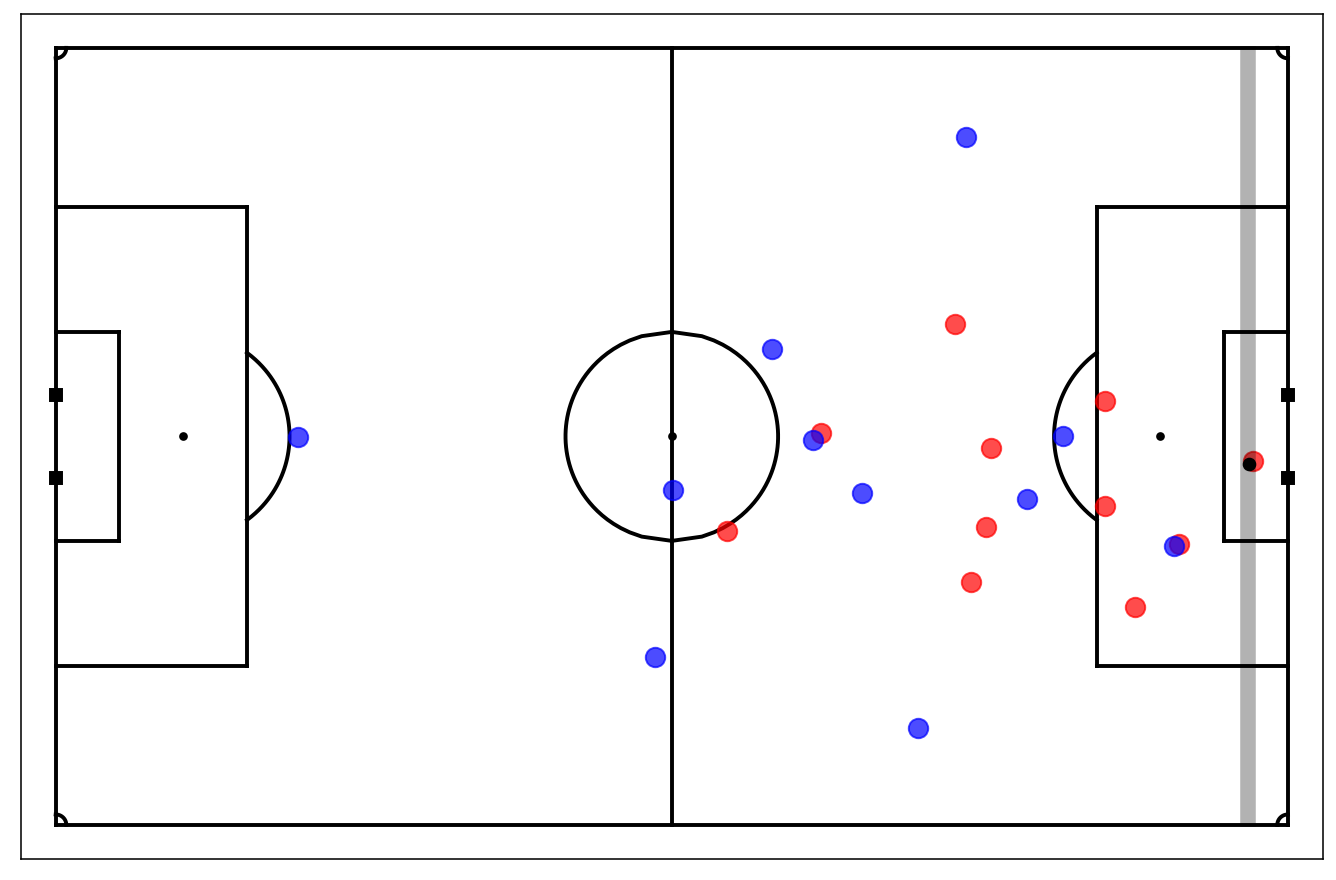

In [9]:
def vis_rest_defence(hometeam, awayteam, frame=1):
    """ Visualizes line used to calculate rest defence
    
    Args:
        hometeam: row (i.e. instant) of the home team tracking data frame
        awayteam: row of the away team tracking data frame
        frame: Integer representing the frame number for the calculation
    
    Returns:
           fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)
    """
    # get basic pitch
    fig, ax = mviz.plot_frame(hometeam.loc[frame], awayteam.loc[frame], PlayerAlpha=0.7)

    # Get coordinates of the extreme players
    x_ball = hometeam.iloc[frame]['ball_x']

        
    # draw line
    ax.plot([x_ball, x_ball], [-33.5, 33.5], linestyle='solid', color='black', linewidth= 8, 
            alpha = 0.3)
    return fig, ax
vis_rest_defence(tracking_home, tracking_away, 19485)

(<Figure size 1680x1120 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x210e233b948>)

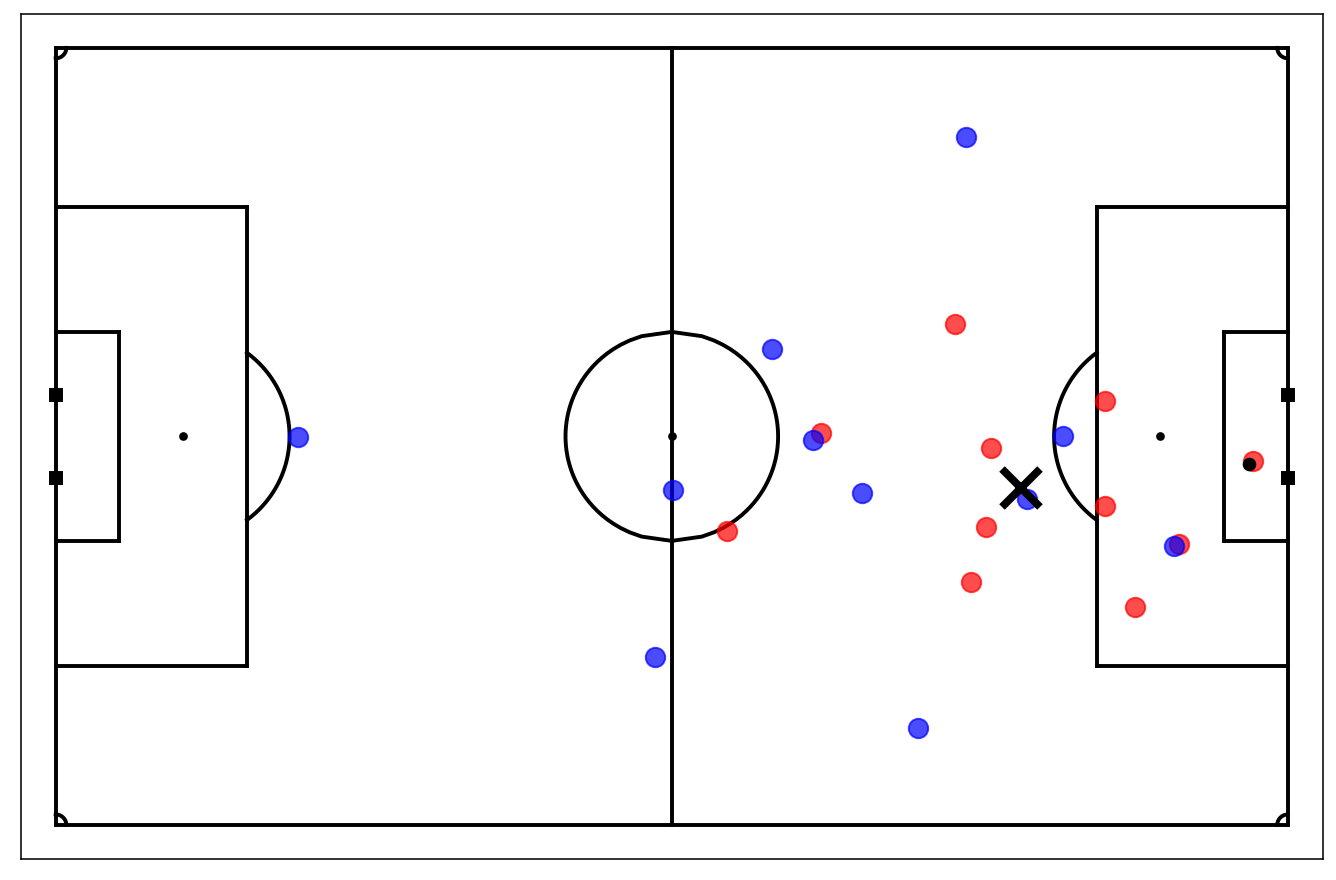

In [10]:
# team centroid
x_centroid, y_centroid = team_centroid(coordinates)
vis_team_centroid(tracking_home, tracking_away, x_centroid, y_centroid, frame=19485, side='home')


[13.24744]
[86.13392]
[81.24744]
[18.13392]


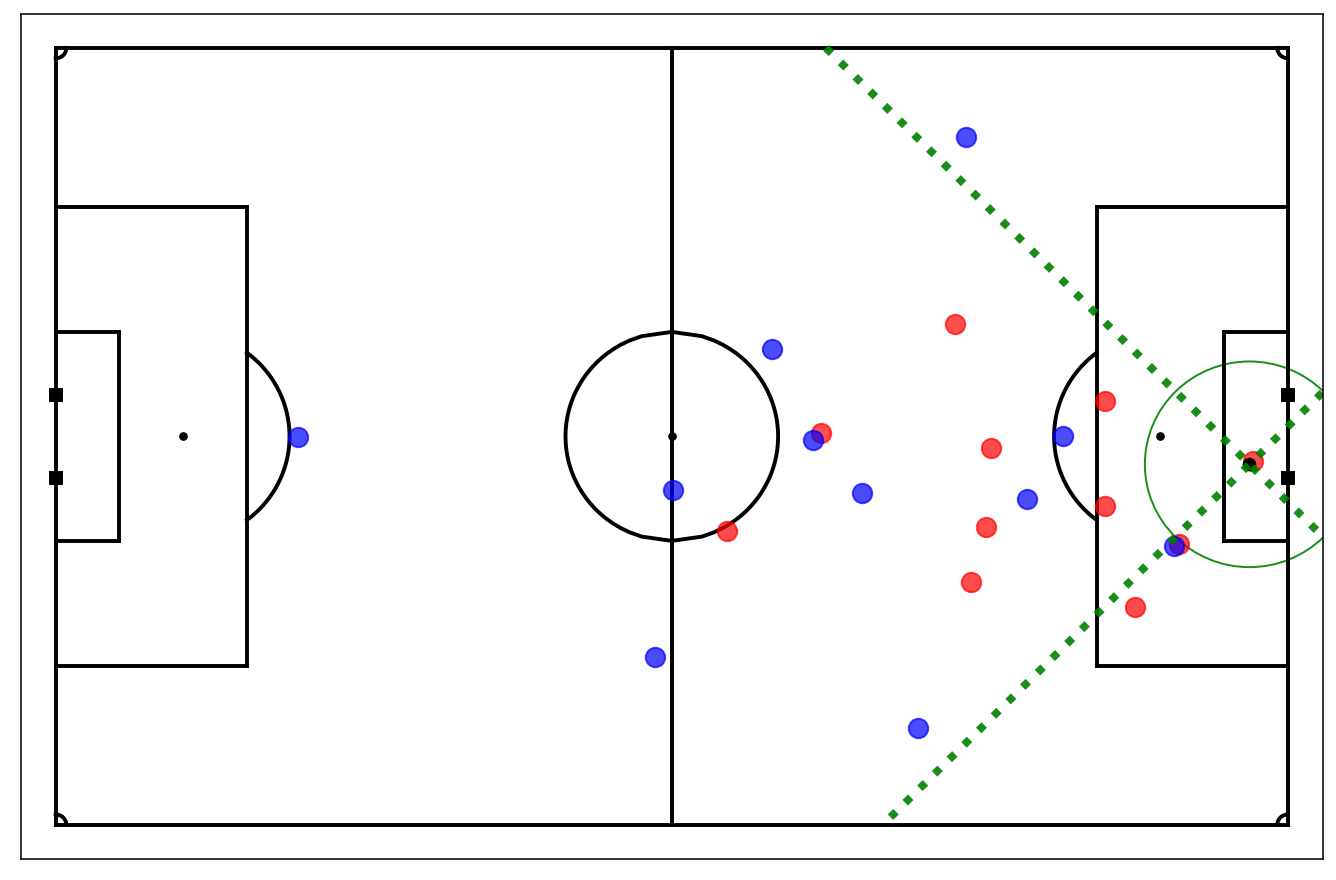

In [11]:
# Visualize relative occupancy map

import math
frame_second = 19485
x_ball = tracking_home.loc[tracking_home.index==frame_second, ['ball_x']].values[0]
y_ball = tracking_home.loc[tracking_home.index==frame_second, ['ball_y']].values[0]
fig, ax = mviz.plot_frame(tracking_home.loc[frame_second], tracking_away.loc[frame_second], PlayerAlpha=0.7)
circ=plt.Circle((x_ball,y_ball), radius=9, color='green', fill=False, linewidth=1, alpha=0.9)

#oldskool goniometry
x_line_ru =x_ball + math.tan(math.radians(45)) * (abs(34-y_ball))
x_line_lu =x_ball - math.tan(math.radians(45)) * (abs(34-y_ball))
x_line_rb =x_ball + math.tan(math.radians(45)) * (abs(-34-y_ball))
x_line_lb =x_ball - math.tan(math.radians(45)) * (abs(-34-y_ball))

print(x_line_lu)
print(x_line_ru)
print(x_line_rb)
print(x_line_lb)

ax.plot([x_line_lu, x_line_rb], [34, -34], linestyle='dotted', color='green', linewidth= 4, 
            alpha = 0.9)
ax.plot([x_line_ru, x_line_lb], [34, -34], linestyle='dotted', color='green', linewidth= 4, 
            alpha = 0.9)
ax.add_patch(circ)


In [12]:
x_ball

array([49.69068])

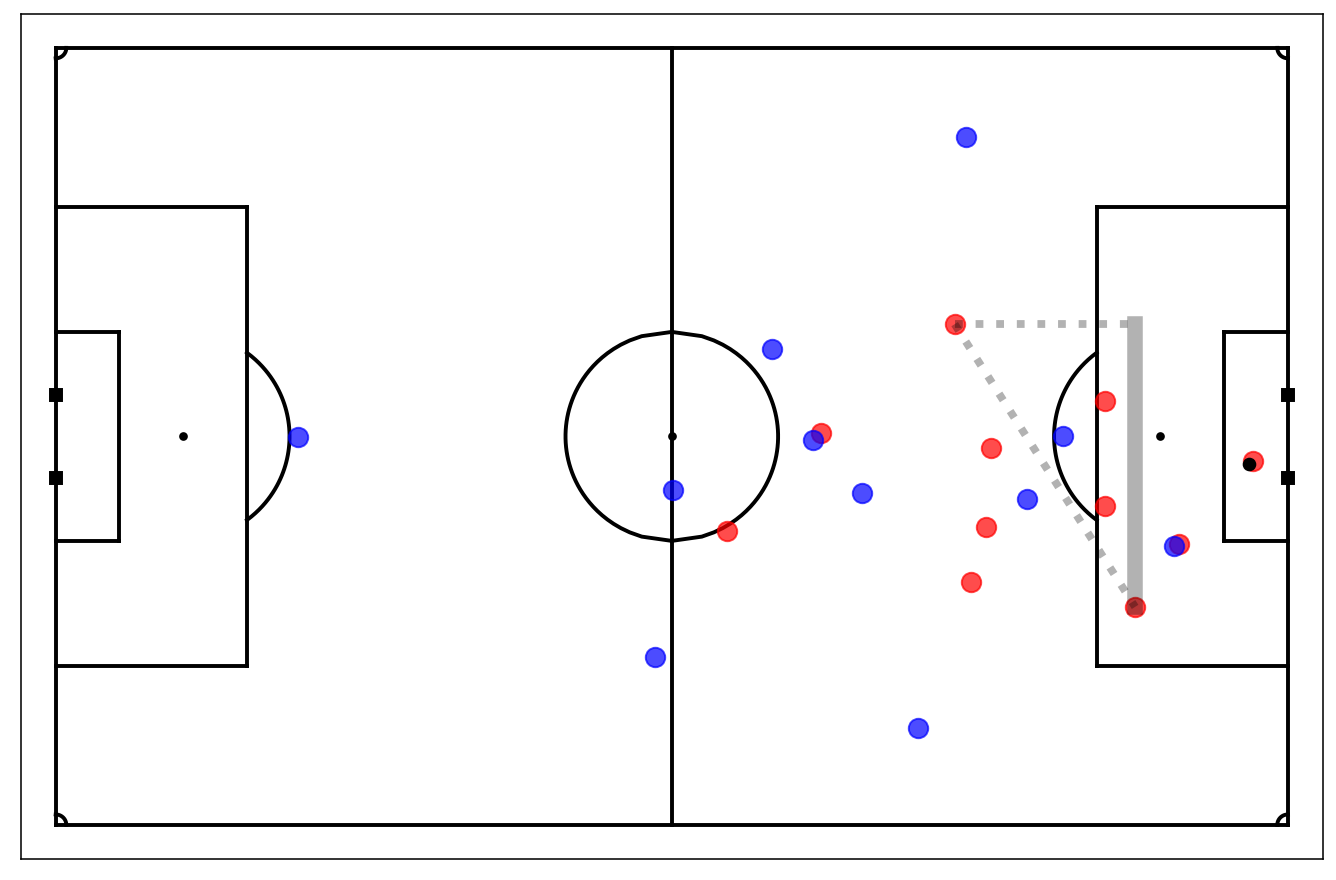

In [13]:
#width
side='home'
# get basic pitch
fig, ax = mviz.plot_frame(tracking_home.loc[19485], tracking_away.loc[19485], PlayerAlpha=0.7)

    # Get coordinates of the extreme players
x_max_player, y_max_player = extrema_axis_player(coordinates, 'max', 'y-axis')
x_min_player, y_min_player = extrema_axis_player(coordinates, 'min', 'y-axis')

    # color
if side=='home':
    colorMarker = 'red'
else:
    colorMarker = 'blue'
        
# draw line
ax.plot([x_max_player, x_min_player], [y_max_player, y_min_player], linestyle='dotted', color='black', linewidth= 4, 
            alpha = 0.3)
ax.plot([x_max_player, x_min_player], [y_max_player, y_max_player], linestyle='dotted', color='black', linewidth= 4, 
            alpha = 0.3)
ax.plot([x_min_player, x_min_player], [y_max_player, y_min_player], linestyle='solid', color='black', linewidth= 8, 
            alpha = 0.3)





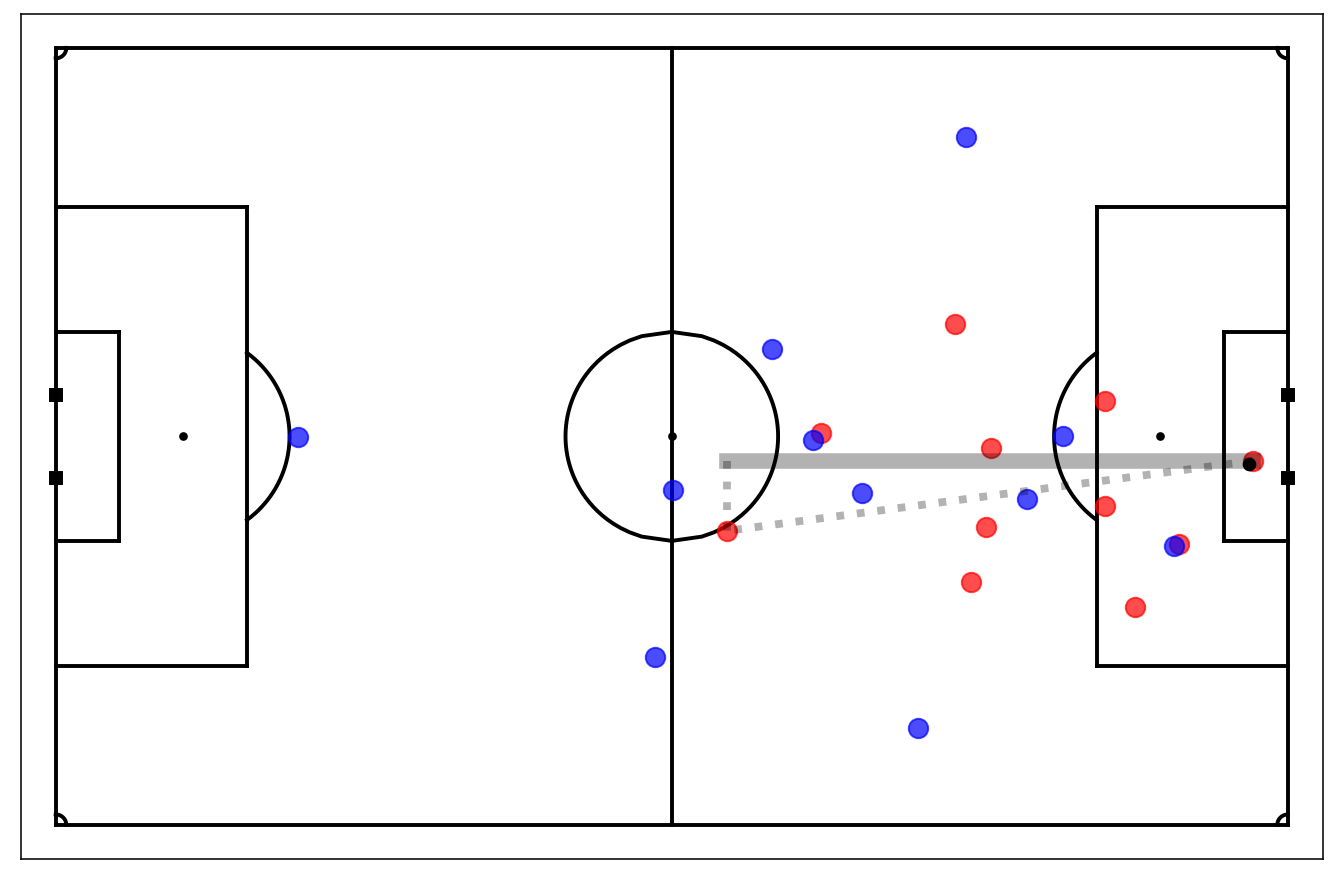

In [14]:
# height
side='home'
# get basic pitch
fig, ax = mviz.plot_frame(tracking_home.loc[19485], tracking_away.loc[19485], PlayerAlpha=0.7)

    # Get coordinates of the extreme players
x_max_player, y_max_player = extrema_axis_player(coordinates, 'max', 'x-axis')
x_min_player, y_min_player = extrema_axis_player(coordinates, 'min', 'x-axis')

    # color
if side=='home':
    colorMarker = 'red'
else:
    colorMarker = 'blue'
        
# draw line
ax.plot([x_max_player, x_min_player], [y_max_player, y_min_player], linestyle='dotted', color='black', linewidth= 4, 
            alpha = 0.3)
ax.plot([x_max_player, x_min_player], [y_max_player, y_max_player], linestyle='solid', color='black', linewidth= 8, 
            alpha = 0.3)
ax.plot([x_min_player, x_min_player], [y_max_player, y_min_player], linestyle='dotted', color='black', linewidth= 4, 
            alpha = 0.3)



In [15]:
# a possession starts upon a player controlling the ball and ends when they no longer do“
# Team Ball Possession (TBP) begins the moment IBP for one of the team’s players begins
#(following IBP of a player on the opposing team or a game interruption). It ends with the
#  first IBP for one of the opposing team’s players following this. cite Individual ball possession in soccer

In [16]:
### Workflow to retrieve phases of possession

# 1 Filter for events that take longer than 1 frame
events = events[events['Start Time [s]'] != events['End Time [s]']]

# 2 Generate list of index where team changes / new phase starts
phase_index = events.ne(events.shift()).filter(like='Team').apply(lambda x: x.index[x].tolist())

# 3 Create identifier for phase
events['phase'] = np.nan
counter = 0
for index, row in events.iterrows():
    if (index in phase_index[0]):
        counter += 1
    events.at[index,'phase'] = counter
    
# 4 Aggregate on phase identifier    
phases = events.groupby('phase').agg(
    Team=('Team', 'first'),
    Start_frame = ('Start Frame', 'first'),
    End_frame = ('End Frame', 'last'),
    Start_time = ('Start Time [s]', 'first'),
    End_time = ('End Time [s]', 'last')
)

# 5 Calculate phase duration in number of frames
phases['Duration_frames'] = phases['End_frame'] - phases['Start_frame']

# 6 Filter such that phases that don't take longer than 75 frames (3s) are removed
phases = phases[phases.Duration_frames >= 75]

# 7 Repeat step 2 for new phase DF
phase_index = phases.ne(phases.shift()).filter(like='Team').apply(lambda x: x.index[x].tolist())

# 8 Repeat step 3 for new phase DF 
counter = 0
for index, row in phases.iterrows():
    if (index in phase_index[0]):
        counter += 1
    phases.at[index,'phase'] = counter
phases.index.names = ['frames']

# 9 repeat step 4 for new phase DF 
phases = phases.groupby('phase').agg(
    Team=('Team', 'first'),
    Start_frame = ('Start_frame', 'first'),
    End_frame = ('End_frame', 'last'),
    Start_time = ('Start_time', 'first'),
    End_time = ('End_time', 'last')
)

# 10 Recalculate duration of phases
phases['Duration_frames'] = phases['End_frame'] - phases['Start_frame']
phases['Duration_time'] = phases['End_time'] - phases['Start_time']

# 11 Mean scores
print(phases.Duration_frames.mean())
print(phases.Duration_time.mean())


662.8148148148148
26.512592592592608


In [17]:
field_dimen = (106.0,68.0)
field_dimen[0]

106.0

In [18]:
def generate_pitch_control_for_event(hometeam, awayteam, possesion_team, params, GK_numbers, frame=1, field_dimen = (106.,68.,), n_grid_cells_x = 50, offsides=True):
    """ generate_pitch_control_for_event
    
    Evaluates pitch control surface over the entire field at the moment of the given event (determined by the index of the event passed as an input)
    
    Parameters
    -----------
        event_id: Index (not row) of the event that describes the instant at which the pitch control surface should be calculated
        events: Dataframe containing the event data
        tracking_home: tracking DataFrame for the Home team
        tracking_away: tracking DataFrame for the Away team
        params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
        GK_numbers: tuple containing the player id of the goalkeepers for the (home team, away team)
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        n_grid_cells_x: Number of pixels in the grid (in the x-direction) that covers the surface. Default is 50.
                        n_grid_cells_y will be calculated based on n_grid_cells_x and the field dimensions
        offsides: If True, find and remove offside atacking players from the calculation. Default is True.
        
    UPDATE (tutorial 4): Note new input arguments ('GK_numbers' and 'offsides')
        
    Returrns
    -----------
        PPCFa: Pitch control surface (dimen (n_grid_cells_x,n_grid_cells_y) ) containing pitch control probability for the attcking team.
               Surface for the defending team is just 1-PPCFa.
        xgrid: Positions of the pixels in the x-direction (field length)
        ygrid: Positions of the pixels in the y-direction (field width)

    """
    # new
    x_ball = hometeam.loc[hometeam.index==frame, ['ball_x']].values[0]
    y_ball = hometeam.loc[hometeam.index==frame, ['ball_y']].values[0]
    ball_start_pos = np.array([x_ball, y_ball])
    
  
    # get the details of the event (frame, team in possession, ball_start_position)
    #pass_frame = events.loc[event_id]['Start Frame']
    #pass_team = events.loc[event_id].Team
    #ball_start_pos = np.array([events.loc[event_id]['Start X'],events.loc[event_id]['Start Y']])
    
    # break the pitch down into a grid
    n_grid_cells_y = int(n_grid_cells_x*field_dimen[1]/field_dimen[0])
    dx = field_dimen[0]/n_grid_cells_x
    dy = field_dimen[1]/n_grid_cells_y
    xgrid = np.arange(n_grid_cells_x)*dx - field_dimen[0]/2. + dx/2.
    ygrid = np.arange(n_grid_cells_y)*dy - field_dimen[1]/2. + dy/2.
    # initialise pitch control grids for attacking and defending teams 
    PPCFa = np.zeros( shape = (len(ygrid), len(xgrid)) )
    PPCFd = np.zeros( shape = (len(ygrid), len(xgrid)) )
    # initialise player positions and velocities for pitch control calc (so that we're not repeating this at each grid cell position)
    if possesion_team=='Home':
        attacking_players = mpc.initialise_players(hometeam.loc[frame],'Home',params,GK_numbers[0])
        defending_players = mpc.initialise_players(awayteam.loc[frame],'Away',params,GK_numbers[1])
    elif possesion_team=='Away':
        defending_players = mpc.initialise_players(hometeam.loc[frame],'Home',params,GK_numbers[0])
        attacking_players = mpc.initialise_players(awayteam.loc[frame],'Away',params,GK_numbers[1])
    else:
        assert False, "Team in possession must be either home or away"
        
    # find any attacking players that are offside and remove them from the pitch control calculation
    if offsides:
        attacking_players = mpc.check_offsides( attacking_players, defending_players, ball_start_pos, GK_numbers)
    # calculate pitch pitch control model at each location on the pitch
    for i in range( len(ygrid) ):
        for j in range( len(xgrid) ):
            target_position = np.array( [xgrid[j], ygrid[i]] )
            PPCFa[i,j],PPCFd[i,j] = mpc.calculate_pitch_control_at_target(target_position, attacking_players, defending_players, ball_start_pos, params)
    # check probabilitiy sums within convergence
    checksum = np.sum( PPCFa + PPCFd ) / float(n_grid_cells_y*n_grid_cells_x ) 
    assert 1-checksum < params['model_converge_tol'], "Checksum failed: %1.3f" % (1-checksum)
    return PPCFa,xgrid,ygrid


In [19]:
params = mpc.default_model_params()
pass_target_pos = np.array([10, 10])
pass_start_pos = None
# find goalkeepers for offside calculation
GK_numbers = [mio.find_goalkeeper(tracking_home),mio.find_goalkeeper(tracking_away)]
PPCFa, xgrid, ygrid = generate_pitch_control_for_event(tracking_home, tracking_away, "Home", params, GK_numbers, 1000)


In [20]:
def plot_pitchcontrol_for_frame(possession_team, tracking_home, tracking_away, PPCF, frame=1, alpha = 0.7, include_player_velocities=True, annotate=False, field_dimen = (106.0,68)):
    """ plot_pitchcontrol_for_event( event_id, events,  tracking_home, tracking_away, PPCF )
    
    Plots the pitch control surface at the instant of the event given by the event_id. Player and ball positions are overlaid.
    
    Parameters
    -----------
        event_id: Index (not row) of the event that describes the instant at which the pitch control surface should be calculated
        events: Dataframe containing the event data
        tracking_home: (entire) tracking DataFrame for the Home team
        tracking_away: (entire) tracking DataFrame for the Away team
        PPCF: Pitch control surface (dimen (n_grid_cells_x,n_grid_cells_y) ) containing pitch control probability for the attcking team (as returned by the generate_pitch_control_for_event in Metrica_PitchControl)
        alpha: alpha (transparency) of player markers. Default is 0.7
        include_player_velocities: Boolean variable that determines whether player velocities are also plotted (as quivers). Default is False
        annotate: Boolean variable that determines with player jersey numbers are added to the plot (default is False)
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        
    NB: this function no longer requires xgrid and ygrid as an input
        
    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)

    """    

    # pick a pass at which to generate the pitch control surface
    #pass_frame = events.loc[event_id]['Start Frame']
    #pass_team = events.loc[event_id].Team
    
    # plot frame and event
    fig,ax = mviz.plot_pitch(field_color='white', field_dimen = field_dimen)
    mviz.plot_frame(tracking_home.loc[frame], tracking_away.loc[frame], figax=(fig,ax), PlayerAlpha=alpha, include_player_velocities=include_player_velocities, annotate=annotate )
    #plot_events( events.loc[event_id:event_id], figax = (fig,ax), indicators = ['Marker','Arrow'], annotate=False, color= 'k', alpha=1 )
    
    # plot pitch control surface
    if possession_team=='Home':
        cmap = 'bwr'
    else:
        cmap = 'bwr_r'
    ax.imshow(np.flipud(PPCF), extent=(-field_dimen[0]/2., field_dimen[0]/2., -field_dimen[1]/2., field_dimen[1]/2.),interpolation='spline36',vmin=0.0,vmax=1.0,cmap=cmap,alpha=0.5)

    return fig,ax


(<Figure size 1680x1120 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x210e90d4188>)

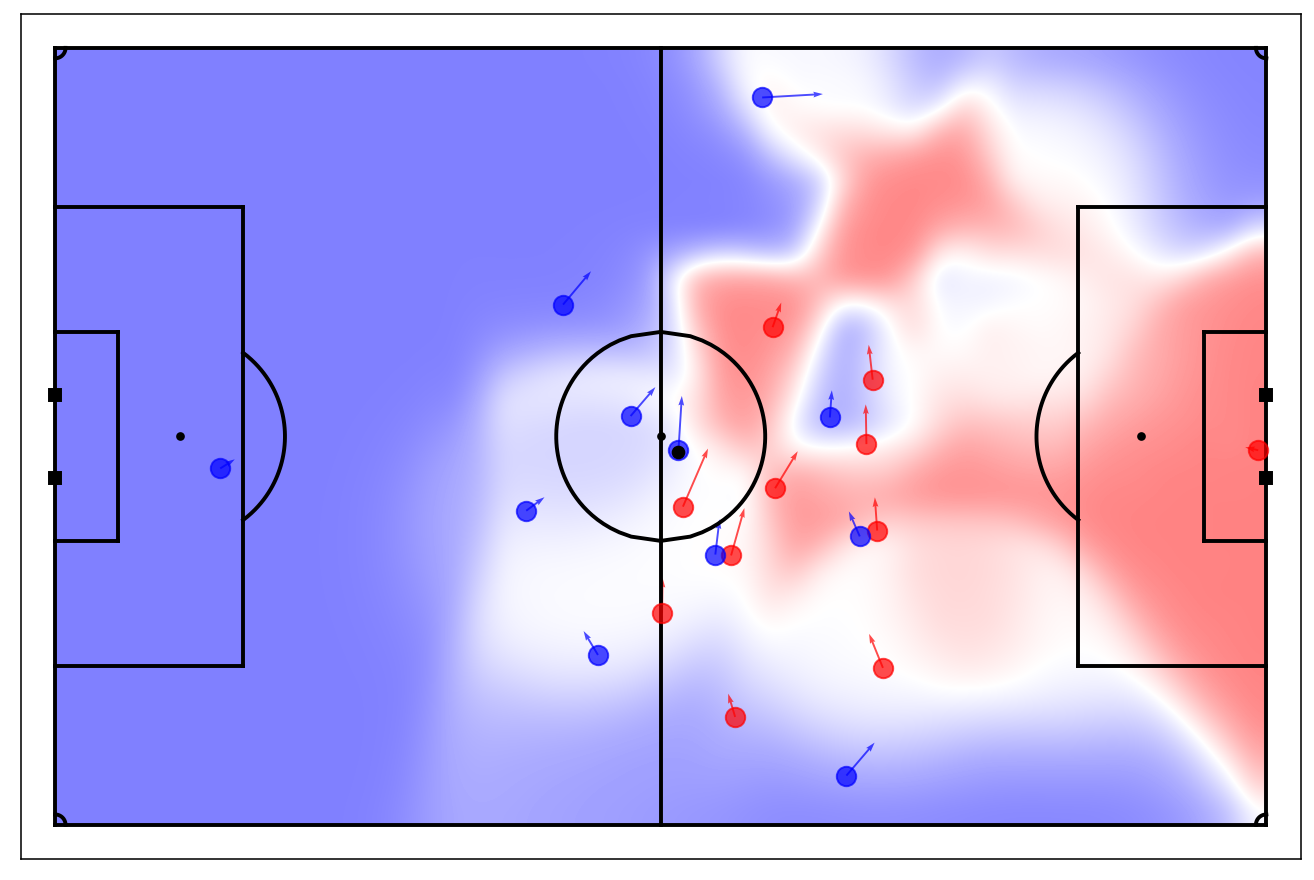

In [21]:
plot_pitchcontrol_for_frame("Home", tracking_home, tracking_away, PPCFa, 100)

In [22]:
# pitch control
#coordinates = get_coordinates(tracking_home, 1, False)
# first get pitch control model parameters
params = mpc.default_model_params()
pass_target_pos = np.array([10, 10])
pass_start_pos = None
# find goalkeepers for offside calculation
GK_numbers = [mio.find_goalkeeper(tracking_home),mio.find_goalkeeper(tracking_away)]
attacking_players = mpc.initialise_players(tracking_home.loc[10],'Home',params, GK_numbers[0])
defending_players = mpc.initialise_players(tracking_away.loc[10],'Away',params, GK_numbers[1])
Patt, Pdef = mpc.calculate_pitch_control_at_target(pass_target_pos, attacking_players, defending_players, pass_start_pos, params)
